In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


# Data preperation

In [2]:
df = pd.read_csv("../data/processed/clients.csv")
print(df.shape)
print(df.columns)
df.head()

(2397, 30)
Index(['customer_id', 'total_spent', 'avg_order_value', 'total_orders',
       'total_items', 'avg_discount', 'avg_review_rating', 'avg_seller_rating',
       'avg_delivery_days', 'total_returns', 'return_ratio',
       'total_previous_returns', 'is_prime_member', 'customer_tenure_days',
       'last_order_date', 'first_order_date', 'recency_days', 'tenure_days',
       'frequency', 'gender', 'region', 'age', 'registration_date', 'source',
       'name', 'email', 'phone', 'income_segment', 'loyalty_status',
       'is_active'],
      dtype='object')


,customer_id,total_spent,avg_order_value,total_orders,total_items,avg_discount,avg_review_rating,avg_seller_rating,avg_delivery_days,total_returns,...,region,age,registration_date,source,name,email,phone,income_segment,loyalty_status,is_active
0,C10000,58.88,29.440,2,2,0.005,5.0,4.145,1.0,0,...,North,28,2023-02-05 15:38:10,E-Shop,Allison Hill,allison.hill@e-shop.com,+161-122-3386,Low Income,Bronze,1
1,C10004,118.49,59.245,2,2,0.000,1.0,4.290,4.0,1,...,North,46,2018-05-21 18:54:38,E-Shop,Noah Rhodes,noah.rhodes@e-shop.com,+130-993-8425,Middle Income,Bronze,0
2,C10005,30.46,15.230,2,2,0.005,5.0,4.160,5.0,0,...,North,46,2019-12-24 03:07:18,Mobile App,Angie Henderson,angie.henderson@mobileapp.com,+001-731-7912,Low Income,Bronze,1
3,C10006,0.00,0.000,1,1,0.010,4.0,4.210,4.0,1,...,South,47,2021-08-23 15:47:17,Mobile App,Daniel Wagner,daniel.wagner@mobileapp.com,+787-255-8777,Low Income,Bronze,0
4,C10007,154.50,154.500,1,1,0.000,3.0,3.360,3.0,0,...,West,55,2018-01-30 12:59:47,E-Shop,Cristian Santos,cristian.santos@e-shop.com,+190-333-7363,Middle Income,Bronze,0


feature selection and necessary cleaning

In [3]:
# Drop rows with missing values (optional)
df.dropna(subset=['frequency', 'gender'], inplace=True)

print(df.shape)
df.head()

(2397, 30)


,customer_id,total_spent,avg_order_value,total_orders,total_items,avg_discount,avg_review_rating,avg_seller_rating,avg_delivery_days,total_returns,...,region,age,registration_date,source,name,email,phone,income_segment,loyalty_status,is_active
0,C10000,58.88,29.440,2,2,0.005,5.0,4.145,1.0,0,...,North,28,2023-02-05 15:38:10,E-Shop,Allison Hill,allison.hill@e-shop.com,+161-122-3386,Low Income,Bronze,1
1,C10004,118.49,59.245,2,2,0.000,1.0,4.290,4.0,1,...,North,46,2018-05-21 18:54:38,E-Shop,Noah Rhodes,noah.rhodes@e-shop.com,+130-993-8425,Middle Income,Bronze,0
2,C10005,30.46,15.230,2,2,0.005,5.0,4.160,5.0,0,...,North,46,2019-12-24 03:07:18,Mobile App,Angie Henderson,angie.henderson@mobileapp.com,+001-731-7912,Low Income,Bronze,1
3,C10006,0.00,0.000,1,1,0.010,4.0,4.210,4.0,1,...,South,47,2021-08-23 15:47:17,Mobile App,Daniel Wagner,daniel.wagner@mobileapp.com,+787-255-8777,Low Income,Bronze,0
4,C10007,154.50,154.500,1,1,0.000,3.0,3.360,3.0,0,...,West,55,2018-01-30 12:59:47,E-Shop,Cristian Santos,cristian.santos@e-shop.com,+190-333-7363,Middle Income,Bronze,0


In [4]:
# Numeric features related to spending and engagement
num_features = [
    'total_spent', 'avg_order_value', 'total_orders',
    'frequency', 'recency_days', 'tenure_days', 'avg_discount',
    'avg_review_rating', 'avg_delivery_days', 'age'
]
# Categorical features for segmentation context
cat_features = ['gender', 'region', 'source', 'is_prime_member', 'loyalty_status']

In [5]:
# Check unique values and their frequencies
for col in cat_features:
    print(f"\n🟦 {col.upper()} — {df[col].nunique()} unique values")
    print(df[col].value_counts(dropna=False))


🟦 GENDER — 2 unique values
gender
Female    1321
Male      1076
Name: count, dtype: int64

🟦 REGION — 4 unique values
region
South    863
East     584
North    547
West     403
Name: count, dtype: int64

🟦 SOURCE — 3 unique values
source
E-Shop        1337
Mobile App     815
Manual         245
Name: count, dtype: int64

🟦 IS_PRIME_MEMBER — 2 unique values
is_prime_member
1    1561
0     836
Name: count, dtype: int64

🟦 LOYALTY_STATUS — 2 unique values
loyalty_status
Bronze    1708
Silver     689
Name: count, dtype: int64


feature encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode nominal categorical features
label_cols = ['gender', 'region', 'source']
for col in label_cols:
    le = LabelEncoder()
    df[f"{col}_encoded"] = le.fit_transform(df[col].astype(str))

# Encode loyalty_status manually (ordered: Bronze < Silver < Gold)
status_map = {'Bronze': 0, 'Silver': 1, 'Gold': 2}
df['loyalty_status_encoded'] = df['loyalty_status'].map(status_map)

# Drop original text columns
df = df.drop(columns=label_cols + ['loyalty_status'])

In [7]:
# confirm the new encoded columns
df[['gender_encoded', 'region_encoded', 'source_encoded', 'loyalty_status_encoded']].head()

,gender_encoded,region_encoded,source_encoded,loyalty_status_encoded
0,0,1,0,0
1,1,1,0,0
2,1,1,2,0
3,1,2,2,0
4,0,3,0,0


In [8]:
df

,customer_id,total_spent,avg_order_value,total_orders,total_items,avg_discount,avg_review_rating,avg_seller_rating,avg_delivery_days,total_returns,...,registration_date,name,email,phone,income_segment,is_active,gender_encoded,region_encoded,source_encoded,loyalty_status_encoded
0,C10000,58.88,29.440000,2,2,0.0050,5.000000,4.145000,1.000000,0,...,2023-02-05 15:38:10,Allison Hill,allison.hill@e-shop.com,+161-122-3386,Low Income,1,0,1,0,0
1,C10004,118.49,59.245000,2,2,0.0000,1.000000,4.290000,4.000000,1,...,2018-05-21 18:54:38,Noah Rhodes,noah.rhodes@e-shop.com,+130-993-8425,Middle Income,0,1,1,0,0
2,C10005,30.46,15.230000,2,2,0.0050,5.000000,4.160000,5.000000,0,...,2019-12-24 03:07:18,Angie Henderson,angie.henderson@mobileapp.com,+001-731-7912,Low Income,1,1,1,2,0
3,C10006,0.00,0.000000,1,1,0.0100,4.000000,4.210000,4.000000,1,...,2021-08-23 15:47:17,Daniel Wagner,daniel.wagner@mobileapp.com,+787-255-8777,Low Income,0,1,2,2,0
4,C10007,154.50,154.500000,1,1,0.0000,3.000000,3.360000,3.000000,0,...,2018-01-30 12:59:47,Cristian Santos,cristian.santos@e-shop.com,+190-333-7363,Middle Income,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,C12993,305.33,76.332500,4,5,0.0075,4.000000,3.767500,2.000000,4,...,2022-10-27 07:04:30,Gina Spencer,gina.spencer@e-shop.com,+1-560-199-9162,High Income,0,0,1,0,1
2393,C12996,189.05,63.016667,3,3,0.0000,4.666667,3.216667,2.666667,2,...,2019-11-17 08:15:22,Alisha Byrd,alisha.byrd@e-shop.com,+517-973-6799,Middle Income,0,1,2,0,1
2394,C12997,59.95,59.950000,1,1,0.0000,5.000000,4.120000,3.000000,0,...,2018-09-12 08:29:07,Richard Rodriguez,richard.rodriguez@mobileapp.com,+1-909-520-3872,Low Income,0,0,1,2,0
2395,C12998,96.14,96.140000,1,1,0.0000,5.000000,3.500000,3.000000,0,...,2020-02-08 00:03:11,Elizabeth Allen,elizabeth.allen@mobileapp.com,+1-215-190-4562,Middle Income,0,0,0,2,0


In [9]:
# combine behavioral and demographic signals
features = [
    'total_spent', 'avg_order_value', 'total_orders',
    'frequency', 'recency_days', 'tenure_days', 'age',
    'avg_discount', 'is_prime_member',
    'gender_encoded', 'region_encoded', 'source_encoded', 'loyalty_status_encoded'
]

X = df[features].copy()

feature scaling

In [10]:
# Scale numeric values ( Scaling ensures that large-valued features (like CLV) don’t dominate the clustering )
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering : K-Means for unsupervised learning

Clustering groups who customers are (based on patterns).

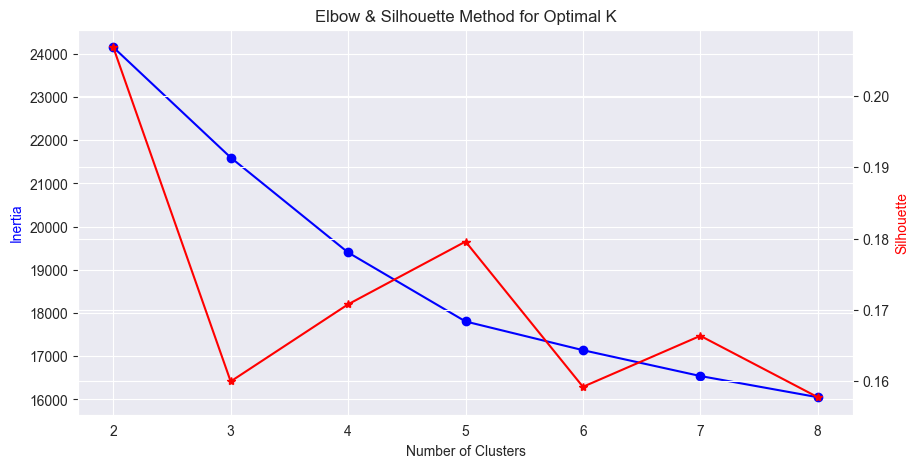

In [11]:
# Find optimal number of clusters (Elbow & Silhouette)
# Choose the k where:
# ===== Inertia curve starts to flatten (the “elbow”)
# ===== Silhouette score is highest
inertia = []
silhouette = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(range(2,9), inertia, 'bo-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='b')

ax2 = ax1.twinx()
ax2.plot(range(2,9), silhouette, 'r*-', label='Silhouette Score')
ax2.set_ylabel('Silhouette', color='r')

plt.title("Elbow & Silhouette Method for Optimal K")
plt.show()

In [12]:
# Apply final clustering : Kmeans
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)
# Cluster sizes
print("Cluster sizes:\n", df['cluster'].value_counts())


Cluster sizes:
 cluster
0    694
3    674
1    582
2    447
Name: count, dtype: int64


In [13]:
cluster_profile = df.groupby('cluster')[features].mean().round(2)
print(cluster_profile)

         total_spent  avg_order_value  total_orders  frequency  recency_days  \
cluster                                                                        
0             236.55            69.08          3.50       0.40        135.02   
1               0.42             0.21          1.04      29.28        304.86   
2             173.07           135.87          1.17      25.35        299.89   
3              87.17            43.58          2.00       0.77        188.58   

         tenure_days    age  avg_discount  is_prime_member  gender_encoded  \
cluster                                                                      
0             329.79  37.89          0.01             0.87            0.44   
1               1.95  39.39          0.01             0.44            0.47   
2              22.92  39.49          0.00             0.44            0.47   
3             206.22  38.04          0.01             0.74            0.42   

         region_encoded  source_encoded  loyalty_s

Visualize clusters

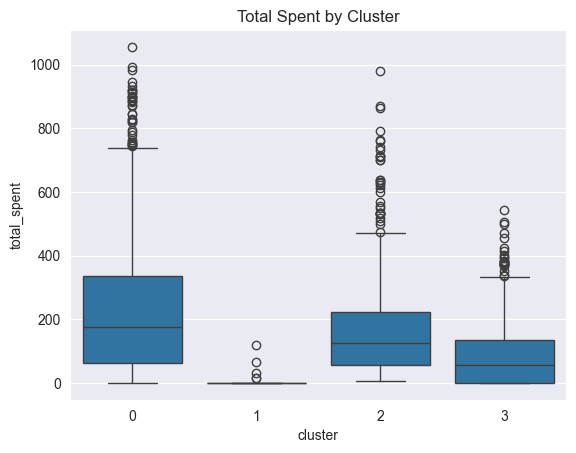

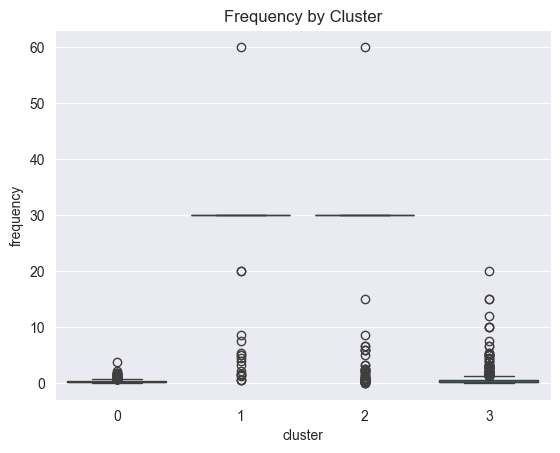

In [14]:
sns.boxplot(x='cluster', y='total_spent', data=df)
plt.title("Total Spent by Cluster")
plt.show()

sns.boxplot(x='cluster', y='frequency', data=df)
plt.title("Frequency by Cluster")
plt.show()

PCA based visualization

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]


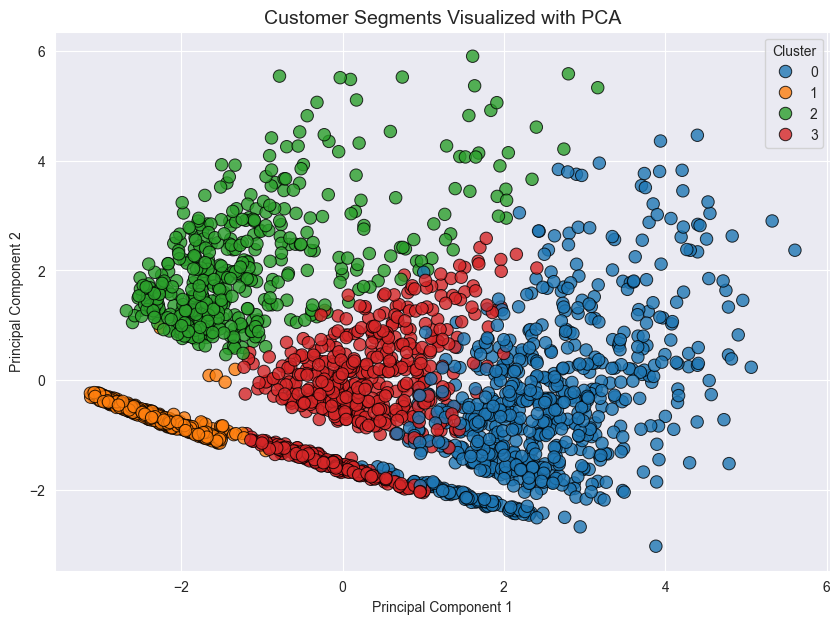

In [17]:
# Visualize clusters in 2D
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df,
    x='pca_1',
    y='pca_2',
    hue='cluster',   # or use 'cluster' if you didn’t map segment names
    palette='tab10',
    alpha=0.8,
    s=80,
    edgecolor='k'
)
plt.title("Customer Segments Visualized with PCA", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()


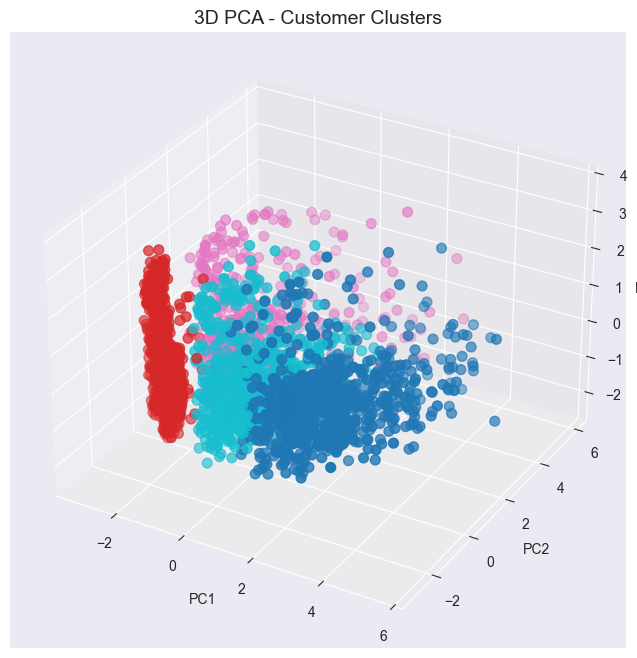

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# 3 components for 3D visualization
pca_3d = PCA(n_components=3, random_state=42)
X_pca3 = pca_3d.fit_transform(X_scaled)

df['pca_3'] = X_pca3[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['pca_1'], df['pca_2'], df['pca_3'], c=df['cluster'], cmap='tab10', s=50)
ax.set_title("3D PCA - Customer Clusters", fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


In [19]:
# how much information (variance) PCA kept from the original data
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance captured:", round(sum(pca.explained_variance_ratio_) * 100, 2), "%")

Explained variance ratio: [0.3020736  0.16010822]
Total variance captured: 46.22 %


KPI extraction

In [20]:
# Aggregate Cluster Metrics
kpi_cols = ['total_spent', 'avg_order_value', 'frequency', 'recency_days', 'loyalty_status_encoded']
cluster_kpis = df.groupby('cluster')[kpi_cols].mean().round(2)
print(cluster_kpis)

         total_spent  avg_order_value  frequency  recency_days  \
cluster                                                          
0             236.55            69.08       0.40        135.02   
1               0.42             0.21      29.28        304.86   
2             173.07           135.87      25.35        299.89   
3              87.17            43.58       0.77        188.58   

         loyalty_status_encoded  
cluster                          
0                          0.99  
1                          0.00  
2                          0.00  
3                          0.00  


In [21]:
# Add Cluster Labels
labels = {
    0: "High-Value Loyalists",
    1: "Dormant Clients",
    2: "Regular Buyers",
    3: "Occasional Shoppers"
}
df["segment_label"] = df["cluster"].map(labels)

In [22]:
# Create a Dashboard DataFrame
dashboard_df = df.groupby("segment_label").agg({
    "total_spent": ["mean", "sum"],
    "frequency": "mean",
    "recency_days": "mean",
    "age": "mean",
    "is_prime_member": "mean",
    "customer_id": "count"
}).round(2)

dashboard_df.columns = ["avg_spent", "total_spent", "avg_frequency", "avg_recency", "avg_age", "prime_ratio", "num_clients"]
dashboard_df.reset_index(inplace=True)
dashboard_df

,segment_label,avg_spent,total_spent,avg_frequency,avg_recency,avg_age,prime_ratio,num_clients
0,Dormant Clients,0.42,244.66,29.28,304.86,39.39,0.44,582
1,High-Value Loyalists,236.55,164162.33,0.40,135.02,37.89,0.87,694
2,Occasional Shoppers,87.17,58751.44,0.77,188.58,38.04,0.74,674
3,Regular Buyers,173.07,77362.79,25.35,299.89,39.49,0.44,447


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27040\3943021414.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dashboard_df, x="segment_label", y="total_spent", palette="viridis")


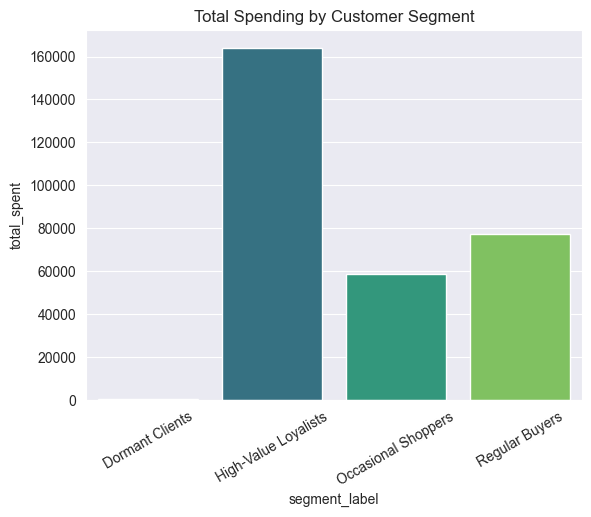

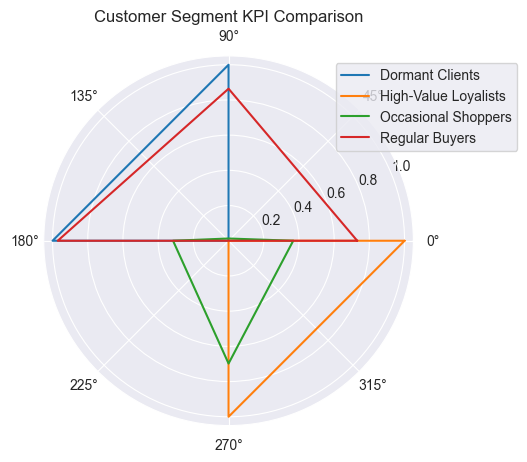

In [23]:
# Visualize KPIs

# Bar Plot
sns.barplot(data=dashboard_df, x="segment_label", y="total_spent", palette="viridis")
plt.title("Total Spending by Customer Segment")
plt.xticks(rotation=30)
plt.show()

# Radar Chart
from math import pi

# Normalize values
values = dashboard_df[["avg_spent", "avg_frequency", "avg_recency", "prime_ratio"]]
values = (values - values.min()) / (values.max() - values.min())

categories = list(values.columns)
num_vars = len(categories)

for i, row in dashboard_df.iterrows():
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    values_row = values.loc[i].tolist()
    values_row += values_row[:1]
    angles += angles[:1]
    plt.polar(angles, values_row, label=row["segment_label"])
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Customer Segment KPI Comparison")
plt.show()

# Cohort Analysis

Cohort Analysis shows how long they stay and behave over time.

In [24]:
# create cohort table
df['first_order_date'] = pd.to_datetime(df['first_order_date'])
df['last_order_date'] = pd.to_datetime(df['last_order_date'])
df['cohort_month'] = df['first_order_date'].dt.to_period('M')

In [25]:
# number of months since joining
df['order_month'] = df['last_order_date'].dt.to_period('M')
df['months_since_cohort'] = (df['order_month'] - df['cohort_month']).apply(lambda x: x.n)

In [26]:
# build cohort table
cohort_data = df.groupby(['cohort_month', 'months_since_cohort'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='months_since_cohort', values='customer_id')

# Compute retention rate
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

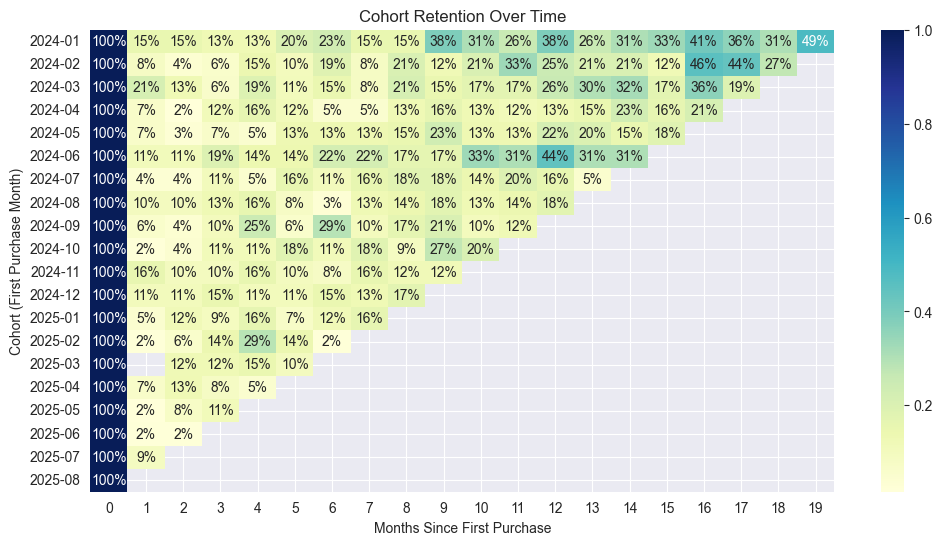

In [27]:
# visualize cohort retention map
plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Cohort Retention Over Time")
plt.ylabel("Cohort (First Purchase Month)")
plt.xlabel("Months Since First Purchase")
plt.show()

📈 Interpretation

Each row = cohort (month when customers first purchased)

Each column = months since first purchase

Each cell = % of customers retained that month

Business Insight:
You’ll see how quickly customers churn after their first month, and whether recent cohorts are improving retention compared to older ones.

# RFM analysis

RFM shows how valuable and active they are right now.

In [28]:
# Prepare RFM Fields
rfm = df[['customer_id', 'recency_days', 'frequency', 'total_spent']].copy()
rfm.rename(columns={'total_spent': 'monetary'}, inplace=True)

In [29]:
# quantile based scores : We assign scores from 1 (low) to 5 (high) for each metric.
rfm['R'] = pd.qcut(rfm['recency_days'], 5, labels=[5,4,3,2,1]).astype(int)  # lower recency = better
rfm['F'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['monetary_jittered'] = rfm['monetary'] + np.random.uniform(0, 1e-5, size=len(rfm))
rfm['M'] = pd.qcut(rfm['monetary_jittered'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()

,customer_id,recency_days,frequency,monetary,R,F,monetary_jittered,M,RFM_Score
0,C10000,17,0.135440,58.88,5,1,58.880004,3,9
1,C10004,338,0.550459,118.49,2,3,118.490008,4,9
2,C10005,28,0.410959,30.46,5,2,30.460002,3,10
3,C10006,113,30.000000,0.00,4,4,0.000005,1,9
4,C10007,436,30.000000,154.50,1,4,154.500004,4,9


In [30]:
# categorize customer segments
def rfm_segment(row):
    if row['RFM_Score'] >= 13:
        return 'Champions'
    elif row['RFM_Score'] >= 10:
        return 'Loyal Customers'
    elif row['RFM_Score'] >= 7:
        return 'Potential Loyalists'
    elif row['RFM_Score'] >= 4:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)
rfm['Segment'].value_counts()

Segment
Potential Loyalists    1215
Loyal Customers         889
At Risk                 220
Champions                73
Name: count, dtype: int64

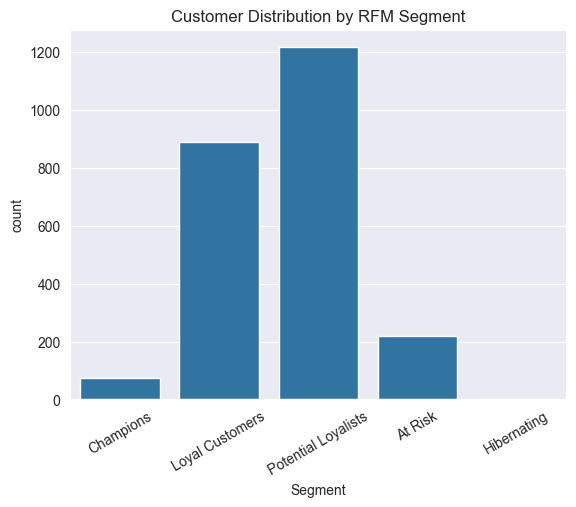

In [31]:
# visualize RFM segments
sns.countplot(data=rfm, x='Segment', order=['Champions','Loyal Customers','Potential Loyalists','At Risk','Hibernating'])
plt.title("Customer Distribution by RFM Segment")
plt.xticks(rotation=30)
plt.show()

# Clients overview

In [32]:
import os
import pandas as pd
import plotly.express as px  # optional: for quick data checks
df_clients = pd.read_csv("../data/processed/clients.csv")
# --- Define export path ---
output_dir = "../data/dash_plotly"
os.makedirs(output_dir, exist_ok=True)

In [33]:
# total active clients
active_clients = df_clients[df_clients['is_active'] == True].shape[0]

In [34]:
# new clients this month
df_clients['registration_date'] = pd.to_datetime(df_clients['registration_date'])
new_clients = df_clients[df_clients['registration_date'].dt.month == pd.Timestamp.now().month].shape[0]

In [35]:
# average order value
aov = df_clients['total_spent'].sum() / df_clients['total_orders'].sum()

In [36]:
# clients retention
df_clients['last_order_date'] = pd.to_datetime(df['last_order_date'])
this_month = pd.Timestamp.now().to_period('M')
retained = df_clients[df_clients['last_order_date'].dt.to_period('M') == this_month].shape[0]

In [37]:
# geographic segmentation
geo_fig = px.bar(
    df_clients.groupby("region")["customer_id"].count().reset_index(),
    x="region", y="customer_id", color="region",
    title="Client Distribution by Region"
)

In [38]:
import os
# Export
clients_overview = df_clients[[
    'customer_id', 'region', 'is_active',
    'total_spent', 'avg_order_value', 'frequency', 'recency_days','source'
]].copy()

clients_overview.to_csv(os.path.join(output_dir,"clients_overview.csv"), index=False)
print("✅ Exported clients_overview.csv")


✅ Exported clients_overview.csv


# Products overview

In [39]:
transactions = pd.read_csv("../data/processed/transactions.csv")
products = pd.read_csv("../data/processed/products.csv")

In [40]:
products

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,review_title,review_content,stock,creation_date,last_updated_date,status,supplier_id
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64.0,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,3,2024-03-04,2024-08-14,active,860020/8/N/P/868
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43.0,4.0,43994.0,"Compatible with all Type C enabled devices, be...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,160,2025-05-19,2025-08-24,active,722656/5/F/C/788
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90.0,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",61,2025-04-07,2025-12-04,active,896951/0/P/P/435
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53.0,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",155,2021-03-05,2021-05-01,active,800531/2/P/N/305
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61.0,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",15,2021-04-23,2021-08-29,active,337496/3/N/M/150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,379.0,919.0,59.0,4.0,1090.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",33,2021-03-30,2021-08-10,active,434382/4/N/M/373
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2280.0,3045.0,25.0,4.1,4118.0,"230 Volts, 400 watts, 1 Year","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the measuri...",1,2024-03-29,2024-05-31,active,501292/0/B/N/317
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",2219.0,3080.0,28.0,3.6,468.0,International design and styling|Two heat sett...,"R1TLRJVW4STY5I,R2O455KRN493R1,R3Q5MVGBRIAS2G,R...","very good,Work but front melt after 2 month,Go...","plastic but cool body ,u have to find sturdy s...",129,2022-11-25,2023-06-16,active,590296/7/F/P/722
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",1399.0,1890.0,26.0,4.0,8031.0,Fan sweep area: 230 MM ; Noise level: (40 - 45...,"R39Q2Y79MM9SWK,R3079BG1NIH6MB,R29A31ZELTZNJM,R...","Fan Speed is slow,Good quality,Good product,go...",I have installed this in my kitchen working fi...,182,2021-11-18,2022-05-07,active,201550/0/A/P/323


In [41]:
# top rated products
top_products = (
    products.groupby("product_id")["rating"]
    .sum()
    .reset_index()
    .sort_values(by="rating", ascending=False)
    .head(10)
)
top_fig = px.bar(top_products, x="product_id", y="rating", color="rating",
                 title="Top-rated Products")

top_products.to_csv(os.path.join(output_dir, "top_rated_products.csv"), index=False)
print("✅ Exported rated_products.csv")

✅ Exported rated_products.csv


In [42]:
# revenue per category
revenue_category = (
    products.groupby("category")["actual_price"]
    .sum()
    .reset_index()
    .sort_values(by="actual_price", ascending=False)
)
rev_fig = px.pie(revenue_category, names="category",values="actual_price",title="Revenue by Category")
revenue_category.to_csv(os.path.join(output_dir, "sales_by_category.csv"), index=False)
print("✅ Exported sales_by_category.csv")

✅ Exported sales_by_category.csv


In [43]:
# stock level
stock_overview = products[['product_id', 'product_name', 'category', 'stock']].copy()

stock_fig = px.bar(
    products.sort_values(by="stock", ascending=True).tail(10),
    x="product_name", y="stock", color="stock",
    title="Stock Level by Product"
)

stock_overview.to_csv(os.path.join(output_dir, "products_overview.csv"), index=False)
print("✅ Exported products_overview.csv")

✅ Exported products_overview.csv


In [44]:
# discount impact on sales
discount_impact = (
    products.groupby('discount_percentage')
    .agg(
        avg_rating=('rating', 'mean'),
        avg_stock=('stock', 'mean'),
        avg_price=('actual_price', 'mean'),
        product_count=('product_id', 'count')
    )
    .reset_index()
)

disc_fig = px.scatter(
    products,
    x="discount_percentage",
    y="rating",
    color="category",
    title="Discount Impact on Product Rating (No Trendline)"
)
discount_impact.to_csv(os.path.join(output_dir, "discount_impact.csv"), index=False)
print("✅ Exported discount_impact.csv")

✅ Exported discount_impact.csv


# Export to dash app

In [45]:
# segmentation and overview
segmentation_df = df[[
    "customer_id",
    "cluster",
    "segment_label",
    "region_encoded",
    "gender_encoded",
    "source_encoded",
    "loyalty_status_encoded",
    "is_prime_member",
    "total_spent",
    "avg_order_value",
    "frequency",
    "recency_days",
    "tenure_days",
    "age",
    "avg_discount",
    "avg_review_rating",
    "avg_delivery_days"
]]

segmentation_df.to_csv("../data/dash_plotly/clients_dashboard_ready.csv", index=False)
print("✅ clients_dashboard_ready.csv exported successfully.")

✅ clients_dashboard_ready.csv exported successfully.


In [46]:
# export KPIs
dashboard_df.to_csv("../data/dash_plotly/segment_kpis.csv", index=False)
print("✅ segment_kpis.csv exported successfully.")

✅ segment_kpis.csv exported successfully.


In [47]:
# export cohort retention
retention.reset_index().to_csv("../data/dash_plotly/cohorts.csv", index=False)
print("✅ cohorts.csv exported successfully.")

✅ cohorts.csv exported successfully.


In [48]:
# export RFM results
rfm[["customer_id", "recency_days", "frequency", "monetary", "R", "F", "M", "RFM_Score", "Segment"]].to_csv(
    "../data/dash_plotly/rfm_scores.csv", index=False
)
print("✅ rfm_scores.csv exported successfully.")

✅ rfm_scores.csv exported successfully.


# Build notification logic

In [49]:
import pandas as pd

def generate_notifications(df):
    notifications = []

    for _, row in df.iterrows():
        # --- Examples of rules ---
        if row['recency_days'] > 120 and row['is_active'] == 0:
            notifications.append({
                'customer_id': row['customer_id'],
                'name': row['name'],
                'segment': row['segment'],
                'type': 'Reactivation',
                'priority': 'High',
                'message': f"{row['name']} has been inactive for over 4 months. Send a re-engagement offer."
            })
        elif row['clv'] > 1500 and row['frequency'] > 0.4:
            notifications.append({
                'customer_id': row['customer_id'],
                'name': row['name'],
                'segment': row['segment'],
                'type': 'Reward',
                'priority': 'Medium',
                'message': f"{row['name']} is a loyal VIP. Offer a loyalty reward."
            })
        elif row['tenure_days'] < 30:
            notifications.append({
                'customer_id': row['customer_id'],
                'name': row['name'],
                'segment': row['segment'],
                'type': 'Welcome',
                'priority': 'Low',
                'message': f"Welcome {row['name']}! Send onboarding email."
            })

    return pd.DataFrame(notifications)

In [50]:
# figure out how to automate and trigger notification

notifications_df = generate_notifications(df)
notifications_df

KeyError: 'clv'